In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
Image_Size= 300
Batch_Size = 96
num_classes = 2

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "real_and_fake_face",
    shuffle=True,
    image_size=(Image_Size, Image_Size),
    batch_size=Batch_Size
)

Found 2041 files belonging to 2 classes.


In [4]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [5]:
train_ds, val_ds = splitting_dataset_tf(dataset)

In [6]:
print(len(train_ds), len(val_ds))

17 4


In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(Image_Size, Image_Size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='LeakyReLU')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(
    optimizer='nadam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_ds,
    epochs=150,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/150


17/17 [==============================] - 51s 3s/step - loss: 57.3596 - accuracy: 0.4971 - val_loss: 46.6104 - val_accuracy: 0.4688
Epoch 2/150
17/17 [==============================] - 46s 3s/step - loss: 21.6828 - accuracy: 0.4939 - val_loss: 8.5933 - val_accuracy: 0.5391
Epoch 3/150
17/17 [==============================] - 44s 3s/step - loss: 11.9926 - accuracy: 0.5259 - val_loss: 6.9636 - val_accuracy: 0.5495
Epoch 4/150
17/17 [==============================] - 45s 3s/step - loss: 8.6349 - accuracy: 0.5381 - val_loss: 2.1746 - val_accuracy: 0.5964
Epoch 5/150
17/17 [==============================] - 46s 3s/step - loss: 6.2235 - accuracy: 0.5573 - val_loss: 2.5920 - val_accuracy: 0.5651
Epoch 6/150
17/17 [==============================] - 44s 3s/step - loss: 5.6511 - accuracy: 0.5426 - val_loss: 3.7763 - val_accuracy: 0.5729
Epoch 7/150
17/17 [==============================] - 44s 3s/step - loss: 5.7464 - accuracy: 0.5420 - val_loss: 1.8306 - val_accuracy: 0.6198
Epoch 8

In [11]:
# Eğitilmiş modeli kaydetme
model.save('150epoch_96batch_nadam_leakyrelu.h5')

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
scores = model.evaluate(val_ds)

4/4 [==============================] - 11s 3s/step - loss: 0.5120 - accuracy: 0.7839


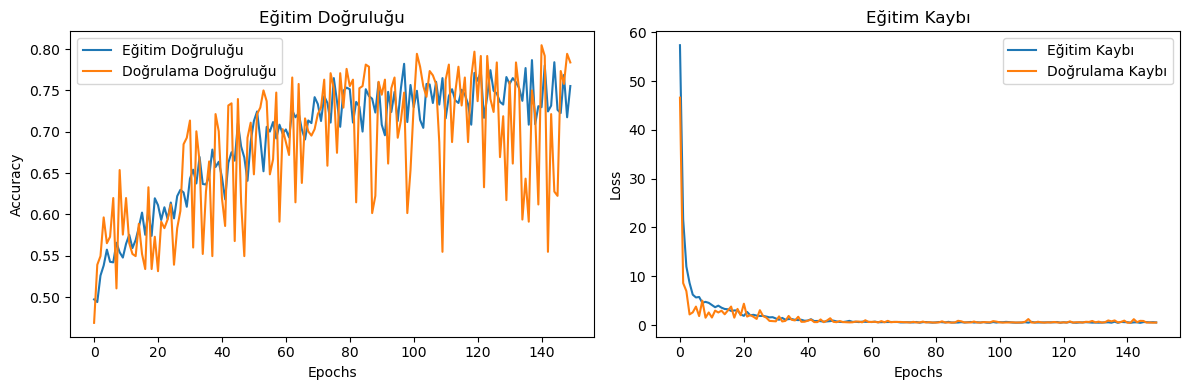

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 [==============================] - 12s 3s/step


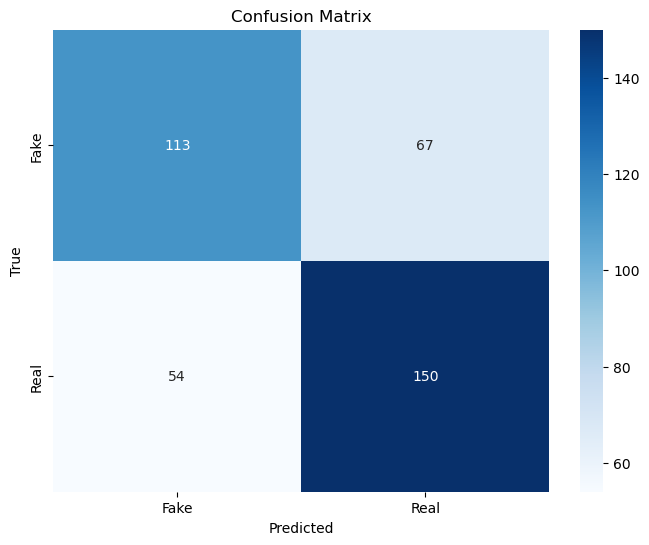

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# Validation veri kümesi üzerinde tahminlerin alınması
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketlerin alınması
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Confusion matrix oluşturma
cm = confusion_matrix(y_true, y_pred_classes)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from sklearn.metrics import classification_report

# Sınıflandırma raporu oluşturma
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.68      0.63      0.65       180
           1       0.69      0.74      0.71       204

    accuracy                           0.68       384
   macro avg       0.68      0.68      0.68       384
weighted avg       0.68      0.68      0.68       384



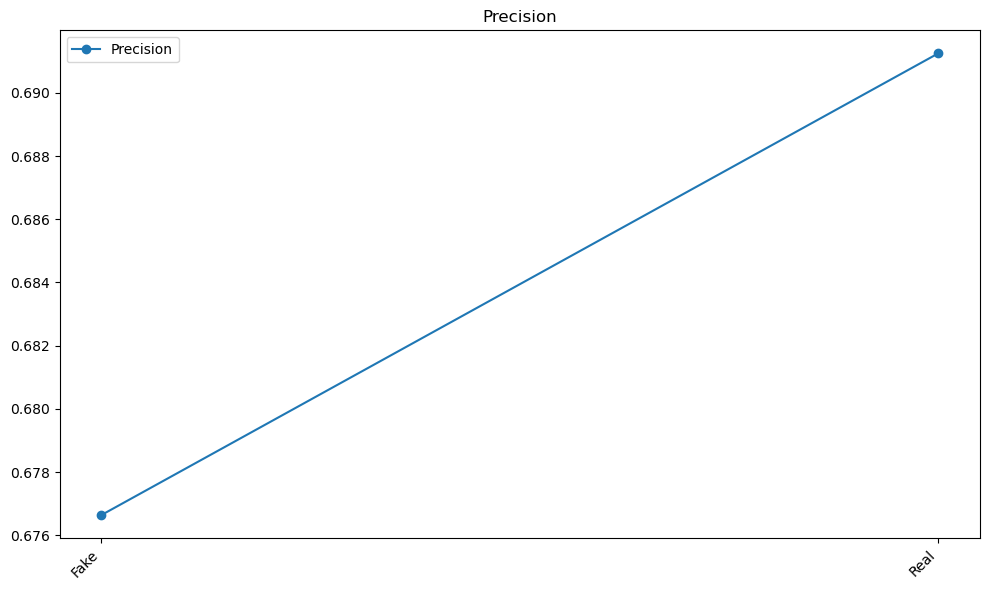

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
precision = precision_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,precision, marker='o', label='Precision')
plt.title('Precision')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

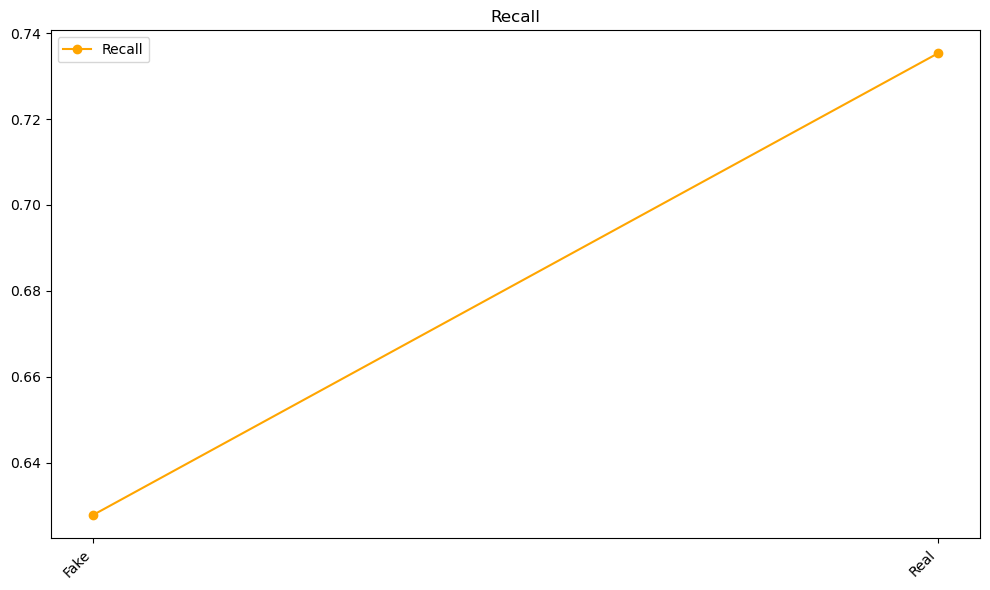

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
recall = recall_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,recall, marker='o',color='orange', label='Recall')
plt.title('Recall')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

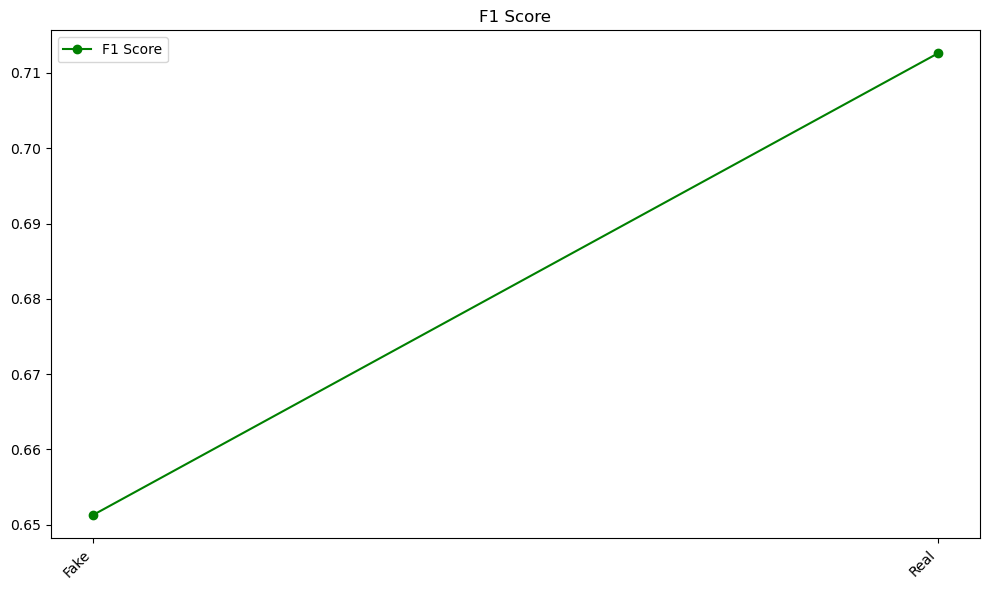

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
f1 = f1_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,f1, marker='o',color='green', label='F1 Score')
plt.title('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

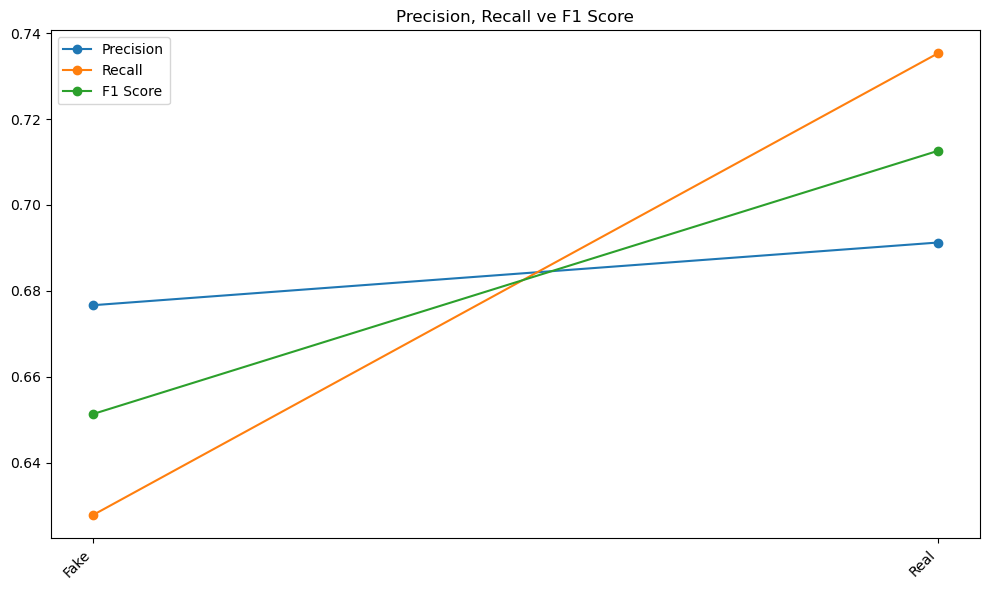

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
folders = xticklabels=["Fake", "Real"]
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Grafikleri çizme
plt.figure(figsize=(10, 6))
plt.plot(folders,precision, marker='o', label='Precision')
plt.plot(folders,recall, marker='o', label='Recall')
plt.plot(folders,f1, marker='o', label='F1 Score')
plt.title('Precision, Recall ve F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()